# 2020 Covid dataset analysed


## Part 1 - Feature Engineering 

In [110]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
import matplotlib.pyplot as plt
import pickle

In [111]:
list_of_df= []
for (root, dirs, files) in os.walk(os.path.join(os.getcwd(), "county_data")):
    for file in files:
        if file[-4:] == ".csv": 
            df = pd.read_csv(os.path.join(root, file))
            df = df.dropna()
            if len(df):
                name = df["areaName"][5]
                df = df.drop(df.columns[:3], axis=1)[::-1].reset_index(drop=True)
                df['y'] = df["newCasesBySpecimenDate"]/df["newVirusTestsBySpecimenDate"]
                for i in range(len(df)):
                    if df["newVirusTestsBySpecimenDate"][i]==0:
                        df.loc[i,'y']=0
                df.columns=['Date','Cases','Deaths','Tests','y']
                #df=df.set_index('Date')
                list_of_df.append([name,df])




In [112]:
list_of_df[0][1]["Tests"][6]

10

count    957.000000
mean       0.038918
std        0.048390
min        0.000000
25%        0.007678
50%        0.027778
75%        0.052632
max        0.555556
Name: y, dtype: float64


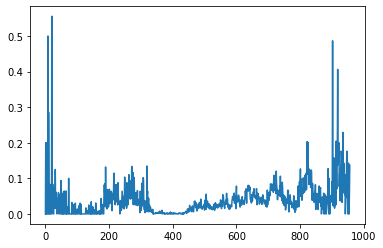

In [113]:
print(list_of_df[16][1].y.describe())
plt.plot(list_of_df[16][1].y)

In [114]:
list_slopes=[]
list_means=[]
for name,data in list_of_df:
    slope, bias = np.polyfit(np.arange(0,data.shape[0]), data.y,1)
    list_slopes.append(slope)
    list_means.append(data.y.mean())

In [115]:
list_slopes

[-7.009352573434715e-05,
 -1.210070596412333e-05,
 1.0924270296073364e-05,
 -2.0524192970930683e-05,
 2.006595093383056e-05,
 1.945946684197738e-05,
 -1.2018401619309772e-05,
 -7.474533231940102e-05,
 -1.7217387846643366e-05,
 -4.388311983779209e-06,
 5.6748354994254236e-06,
 2.856943785056627e-05,
 2.599376530206034e-05,
 2.473585442602515e-05,
 -5.001534209907751e-06,
 -3.926018923010657e-05,
 5.179491050629969e-05,
 -2.6327684556452558e-06,
 3.923584010042349e-06,
 1.3049079947661325e-05,
 -1.5541307305017786e-05,
 2.728561996917576e-05,
 2.4715472430987007e-05,
 1.2991476740786423e-05,
 3.0731495852298025e-05,
 4.895017145299885e-05,
 2.4702871743159333e-05,
 1.0212562507937438e-05,
 2.131646882685008e-05,
 -3.016437475575607e-05,
 7.133410651745553e-06,
 6.976248945578321e-06,
 2.9209488489176565e-06,
 -2.818738759850701e-06,
 1.0876154444565237e-05,
 -2.0070551496553338e-06,
 -7.016067510061868e-05,
 -6.823784136781185e-06,
 -6.141019024327251e-06,
 -3.69094035366433e-07,
 4.0213

In [116]:
list_of_features=['Cases','Deaths','Tests']
list_county=[x[0] for x in list_of_df]

def norm_feature(data,col=None):
    '''
    Given a DataFrame and a column, it normalises the data in a new column called NORM_column
    '''
    if col is None:
        a=(data-data.mean())/data.std()
    else: 
        a=(data[col]-data[col].mean())/data[col].std()
    name='NORM_'+ col
    data[name]=a
    return data

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

features=[]
for name,df in list_of_df:
    for feature in list_of_features:
        a='NORM_'+feature
        if a not in features:
            features.append(a)
        if a not in df.columns:
            df = norm_feature(df, col=feature)


In [117]:
list_of_df[0][1].describe()


,Cases,Deaths,Tests,y,NORM_Cases,NORM_Deaths,NORM_Tests
count,970.000000,970.000000,970.000000,970.000000,9.700000e+02,9.700000e+02,9.700000e+02
mean,37.091753,0.380412,806.815464,0.067686,1.602384e-18,-2.283740e-15,2.815617e-17
std,61.640514,0.844229,743.090305,0.114433,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000,0.000000,4.000000,0.000000,-6.017431e-01,-4.506034e-01,-1.080374e+00
25%,6.000000,0.000000,167.250000,0.021164,-5.044045e-01,-4.506034e-01,-8.606834e-01
50%,20.000000,0.000000,560.500000,0.042134,-2.772811e-01,-4.506034e-01,-3.314745e-01
75%,45.000000,0.000000,1324.500000,0.076801,1.282963e-01,-4.506034e-01,6.966644e-01
max,839.000000,10.000000,3686.000000,2.000000,1.300943e+01,1.139453e+01,3.874609e+00


In [118]:
from warnings import simplefilter
import seaborn as sns
from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor


def pipeline(model, county, label):

    def make_lags(ts, lags, lead_time=1):
        return pd.concat(
            {
                f'y_lag_{i}': ts.shift(i)
                for i in range(lead_time, lags + lead_time)
            },
            axis=1)

    # 14 days of lag features
    y= county[label]
    y = y.copy()*1000
    X = make_lags(y, lags=50).fillna(0.0)

    def make_multistep_target(ts, steps):
        return pd.concat(
            {f'y_step_{i + 1}': ts.shift(-i)
            for i in range(steps)},
            axis=1)

    # Eight-week forecast
    y = make_multistep_target(y, steps=30).dropna()

    # Shifting has created indexes that don't match. Only keep times for
    # which we have both targets and features.
    y, X = y.align(X, join='inner', axis=0)

    # Create splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
    
    model.fit(X_train, y_train)


    return model

In [119]:
list_of_features.append('y')

c:\Users\Eduar\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


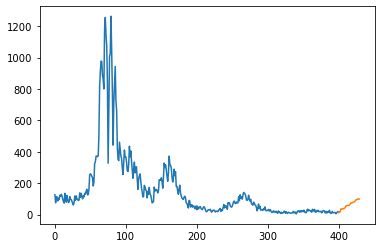

c:\Users\Eduar\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


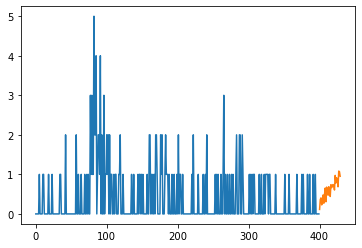

c:\Users\Eduar\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


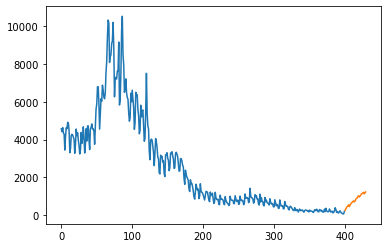

c:\Users\Eduar\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


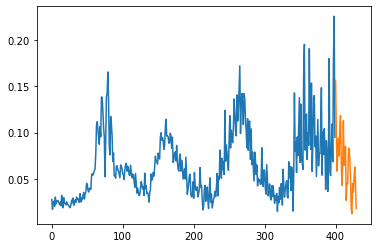

In [120]:
model = LinearRegression()
dict_models=dict()
for feat in list_of_features:
    for i in range(len(list_of_df)//9):
        model = pipeline(model, list_of_df[i][1], feat)
    dict_models[feat]=model

    past_values = 50
    def get_data(n):
        re = list_of_df[n][1][feat]
        values=list(re)
        X = []
        y = []
        for i in range(len(values)-past_values):
            X.append(values[i:i+past_values])
            y.append(values[i+past_values])
        X = np.array(X)
        y = np.array(y)
        return X, y

    X, y = get_data(100)
    # X, y = X[:-220], y[:-220]

    plt.plot(y[-400:])

    shift = 0
    x_axis_future = np.arange(400-30*shift, 400-30*(shift-1))
    if shift: y_future = model.predict(X[-1-shift:-shift])/1000
    else: y_future = model.predict(X[-1-shift:]*1000)/1000
    plt.plot(x_axis_future, y_future[0])
    if shift == 0: y = np.append(y, y_future)
    plt.show()

In [121]:
for name,mod in dict_models.items():
    with open('model_'+name,'wb') as f:
        pickle.dump(mod,f)

In [122]:
prediction_dict = {}
for i in range(len(list_of_df)):
    past_values = 50
    X, y = get_data(i)
    y_future = model.predict(X[-1:]*1000)/1000
    prediction_dict[list_of_df[i][0]] = y_future

c:\Users\Eduar\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Eduar\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Eduar\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Eduar\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Eduar\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Eduar\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not ha

In [123]:
prediction_dict["Cambridgeshire"]
mean=0
for array in prediction_dict.values():
    mean += np.sum(array)
mean = mean/ len(prediction_dict)